In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn import linear_model as lm

from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_percentage_error

from sklearn.preprocessing import StandardScaler


/home/juan/anaconda3/envs/jmb_ds_projects/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
SEED=1992

In [3]:
STATS_COLUMNS = ["player", "position", "age","team_id","g","gs","mp_per_g","fg_per_g",
"fga_per_g","fg_pct","fg3_per_g","fg3a_per_g","fg3_pct","fg2_per_g","fg2a_per_g",
"fg2_pct","efg_pct","ft_per_g","fta_per_g","ft_pct","orb_per_g","drb_per_g","trb_per_g",
"ast_per_g","stl_per_g","blk_per_g","tov_per_g","pf_per_g","pts_per_g"]
NUM_STATS_COLUMNS = [col for col in STATS_COLUMNS if col not in ('"player", "position","team_id"')]

ADVANCED_STATS_COLUMNS =["player","position","age","team_id","g","mp","per","ts_pct","fg3a_per_fga_pct",
"fta_per_fga_pct","orb_pct","drb_pct","trb_pct","ast_pct","stl_pct","blk_pct","tov_pct","usg_pct",
                         "ows","dws","ws","ws_per_48","obpm","dbpm","bpm","vorp"]

NUM_ADVANCED_STATS_COLUMNS = [col for col in ADVANCED_STATS_COLUMNS if col not in ('"player", "position","team_id"')]
INJURIES_COLUMNS = ['out_for_season', 'out_indefinitely','acum_out_for_season', 'acum_out_indefinitely']

In [4]:
df = pd.read_csv('datasets/preprocessed_dataset.csv').fillna(0)
results_df = pd.read_csv('datasets/results/performance_metrics.csv')

In [5]:
relevant_cols = list(set(NUM_STATS_COLUMNS + NUM_ADVANCED_STATS_COLUMNS + ['position'] + INJURIES_COLUMNS))

In [6]:
def evaluate_predictions(model, dataset_type, y_pred, y_truth):
    rmse = np.round(np.sqrt(mean_squared_error(y_truth, y_pred)), 0)
    mae = np.round(median_absolute_error(y_truth, y_pred), 0)
    mape = np.round(mean_absolute_percentage_error(y_truth, y_pred), 4)
    return {'model': [model], 'dataset_type': [dataset_type], 'rmse':[rmse], 'mae': [mae], 'mape':[mape]}

class PredictionEvaluation:
    
    def __init__(self, y_pred_train, y_truth_train, y_pred_test, y_truth_test, model_name, results_df):
        self.y_pred_train = y_pred_train
        self.y_truth_train = y_truth_train
        self.y_pred_test = y_pred_test
        self.y_truth_test = y_truth_test
        self.model_name = model_name
        self.results_df = results_df        
    
    def fill_results_df(self):
        train_results = pd.DataFrame(evaluate_predictions(self.model_name, 'train',
                                                          self.y_pred_train, self.y_truth_train))
        test_results = pd.DataFrame(evaluate_predictions(self.model_name, 'test',
                                                         self.y_pred_test, self.y_truth_test))
        return pd.concat([self.results_df, train_results, test_results])

    def diagnostics_plots(y_pred, y_truth):
    
        diag_plot = pd.DataFrame({'y_pred':y_pred,'y':y_truth, 'error': y_pred-y_truth})
        diag_plot.plot.scatter(x='y',y='y_pred')
        plt.plot([0,max(y_truth)], [0,max(y_truth)], c='black')
        plt.show()

In [7]:
X = df[relevant_cols+['free_agency_year']]
y = df[['mean_salary','free_agency_year']]

In [8]:
X['position'] = X.position.str.split('-').apply(lambda x: x[0])
X = pd.get_dummies(X, columns=["position"])

/home/juan/anaconda3/envs/jmb_ds_projects/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
rel_cols = list(sorted([c for c in X.columns if c!='free_agency_year']))

In [10]:
train_X, test_X = X.query('free_agency_year < 2020').drop('free_agency_year', axis=1).values,\
                  X.query('free_agency_year == 2020').drop('free_agency_year', axis=1).values
train_y, test_y = y.query('free_agency_year < 2020').drop('free_agency_year', axis=1).mean_salary.values,\
                    y.query('free_agency_year == 2020').drop('free_agency_year', axis=1).mean_salary.values

In [11]:
scaler = StandardScaler().fit(train_X)

In [12]:
train_X = scaler.transform(train_X)

In [13]:
test_X = scaler.transform(test_X)

### Lasso

In [14]:
reg = LassoCV(cv=5, random_state=SEED, max_iter=10000, n_alphas=300).fit(train_X, train_y)

In [15]:
mean_mse = np.median(reg.mse_path_, axis=1)
alphas = reg.alphas_
cv_mse_df = pd.DataFrame({'alpha':alphas, 'mean_mse':mean_mse})

In [16]:
reg.alpha_

14304.918736836387

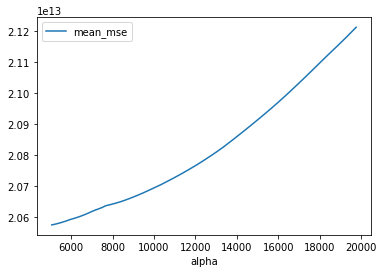

In [17]:
cv_mse_df.query("alpha<20000").plot(x='alpha', y='mean_mse')

In [18]:
clf = lm.Lasso(alpha=reg.alpha_, max_iter=10000, random_state=SEED)

In [19]:
clf.fit(train_X, train_y)

Lasso(alpha=14304.918736836387, max_iter=10000, random_state=1992)

In [20]:
train_y_pred = clf.predict(train_X)
test_y_pred = clf.predict(test_X)

In [21]:
lasso_evaluation = PredictionEvaluation(train_y_pred, train_y, test_y_pred,
                                           test_y, 'lasso', results_df)

results_df = lasso_evaluation.fill_results_df()

### Lasso LARS

In [19]:
from sklearn.linear_model import LassoLarsCV


In [20]:
lasso_lars = LassoLarsCV(cv=5)
lasso_lars.fit(train_X, train_y)

LassoLarsCV(cv=5)

In [23]:
lasso_lars.score(train_X, train_y)

0.6839982057607661

In [24]:
lasso_lars.alpha_

528.2660155361128

In [25]:
lasso_lars.mse_path_

array([[1.44450554e+13, 1.99868164e+13, 2.76779934e+13, 2.19304950e+13,
        2.07277621e+13],
       [1.44450554e+13, 1.99868164e+13, 2.76779934e+13, 2.19304950e+13,
        2.07277621e+13],
       [1.44450554e+13, 1.99868164e+13, 2.76779934e+13, 2.19304950e+13,
        2.07277621e+13],
       ...,
       [2.17798842e+13, 2.64881662e+13, 6.95800284e+13, 7.17533068e+13,
        6.77297476e+13],
       [2.18499124e+13, 2.64881662e+13, 6.95800284e+13, 7.17533068e+13,
        6.77297476e+13],
       [2.21079858e+13, 2.64881662e+13, 6.95800284e+13, 7.17533068e+13,
        6.77297476e+13]])

[]

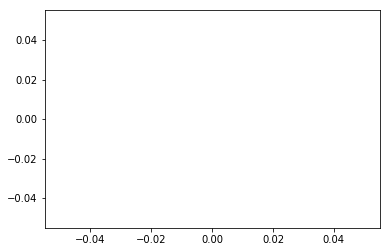

In [31]:
plt.plot(x=range(56), y=lasso_lars.mse_path_)

In [26]:
lasso_lars.n_iter_

56

In [32]:
train_y_pred = lasso_lars.predict(train_X)
test_y_pred = lasso_lars.predict(test_X)

In [33]:
lasso_evaluation = PredictionEvaluation(train_y_pred, train_y, test_y_pred,
                                           test_y, 'lasso_lars', results_df)

In [35]:
results_df = lasso_evaluation.fill_results_df()
results_df

,model,dataset_type,rmse,mae,mape
0,baseline,train,7046669.0,4191739.0,1.7206
1,baseline,test,6136372.0,3988694.0,1.5356
2,modelo lineal,train,3924033.0,2111549.0,0.8302
3,modelo lineal,test,3559228.0,2088352.0,0.8496
4,modelo lineal no negativo,train,4343415.0,2166715.0,0.8812
5,modelo lineal no negativo,test,3798000.0,1817943.0,0.7398
6,modelo lineal logaritmo,train,4492837.0,1382346.0,0.5387
7,modelo lineal logaritmo,test,4095432.0,1059238.0,0.4941
8,lasso,train,3958471.0,2031632.0,0.8034
9,lasso,test,3501706.0,1819077.0,0.7776


## Ridge

In [22]:
reg = RidgeCV(cv=5, alphas=np.arange(0,10,0.05)).fit(train_X, train_y)

/home/juan/anaconda3/envs/jmb_ds_projects/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.67512e-17): result may not be accurate.
  overwrite_a=True).T


In [23]:
reg.alpha_

5.3500000000000005

In [24]:
clf = lm.Ridge(alpha=reg.alpha_, random_state=SEED)

In [25]:
clf.fit(train_X, train_y)

Ridge(alpha=5.3500000000000005, random_state=1992)

In [26]:
train_y_pred = clf.predict(train_X)
test_y_pred = clf.predict(test_X)

ridge_evaluation = PredictionEvaluation(train_y_pred, train_y, test_y_pred,
                                           test_y, 'ridge', results_df)

results_df = ridge_evaluation.fill_results_df()

### Elastic Net

In [27]:
regr = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .975, .99, 1],
                    n_alphas=400,
                    cv=5, max_iter=10000, random_state=SEED).fit(train_X, train_y)

In [28]:
regr.alpha_

14292.499899789696

In [29]:
regr.l1_ratio_

1.0

In [30]:
clf = lm.ElasticNet(alpha=regr.alpha_, l1_ratio=regr.l1_ratio_, max_iter=10000, random_state=SEED)
clf.fit(train_X, train_y)

ElasticNet(alpha=14292.499899789696, l1_ratio=1.0, max_iter=10000,
           random_state=1992)

In [31]:
train_y_pred = clf.predict(train_X)
test_y_pred = clf.predict(test_X)

elastic_evaluation = PredictionEvaluation(train_y_pred, train_y, test_y_pred,
                                           test_y, 'elastic net', results_df)

results_df = elastic_evaluation.fill_results_df()

In [32]:
results_df.to_csv('datasets/results/performance_metrics.csv', index=False)

In [35]:
print(results_df.to_latex())

\begin{tabular}{lllrrr}
\toprule
{} &                      model & dataset\_type &       rmse &        mae &    mape \\
\midrule
0 &                   baseline &        train &  7046669.0 &  4191739.0 &  1.7206 \\
1 &                   baseline &         test &  6136372.0 &  3988694.0 &  1.5356 \\
2 &              modelo lineal &        train &  3924033.0 &  2111549.0 &  0.8302 \\
3 &              modelo lineal &         test &  3559228.0 &  2088352.0 &  0.8496 \\
4 &  modelo lineal no negativo &        train &  4343415.0 &  2166715.0 &  0.8812 \\
5 &  modelo lineal no negativo &         test &  3798000.0 &  1817943.0 &  0.7398 \\
6 &    modelo lineal logaritmo &        train &  4492837.0 &  1382346.0 &  0.5387 \\
7 &    modelo lineal logaritmo &         test &  4095432.0 &  1059238.0 &  0.4941 \\
0 &                      lasso &        train &  3958471.0 &  2031632.0 &  0.8034 \\
0 &                      lasso &         test &  3501706.0 &  1819077.0 &  0.7776 \\
0 &                  

# Regularization with log

In [35]:
lasso_log_cv = LassoCV(cv=5, random_state=SEED, max_iter=10000, n_alphas=300).fit(train_X, np.log(train_y))

In [36]:
lasso_log = lm.Lasso(alpha=lasso_log_cv.alpha_, max_iter=10000, random_state=SEED)

In [37]:
lasso_log.fit(train_X, np.log(train_y))

Lasso(alpha=0.0073195322181818494, max_iter=10000, random_state=1992)

In [38]:
train_y_pred = np.exp(lasso_log.predict(train_X))
test_y_pred = np.exp(lasso_log.predict(test_X))